In [1]:
# Импортируем модули для хранения и визуализации результатов расчёта
import numpy as np
import matplotlib.pyplot as plt
import math as m
from scipy.optimize import newton

In [2]:
# Монотонизация массива
def monoton(array):
    for e in range(1, len(array)-1):
        if (array[e] - array[e-1]) * (array[e+1] - array[e]) < 0:
            array[e] = 0.5 * (array[e+1] + array[e-1])
    return array

In [3]:
gamma = 1.4 # показатель адиабаты газа

In [4]:
# Реализация метода HLL (Хартена - Лакса - ван Лира)
# На вход подаются векторы консервативных переменных и потоков слева и справа от рассматриваемой грани
# Функция возвращает аппроксимацию вектора потоков на грани
def HLL(vec_U_l, vec_U_r, vec_F_l, vec_F_r): 
   u_l = vec_U_l[1] / vec_U_l[0]
   u_r = vec_U_r[1] / vec_U_r[0]
   a_l = (vec_U_l[2] / vec_U_l[0] * (gamma**2 - gamma)) ** 0.5
   a_r = (vec_U_r[2] / vec_U_r[0] * (gamma**2 - gamma)) ** 0.5
   a_av = 0.5 * (a_l + a_r)
   rho_l = vec_U_l[0]
   rho_r = vec_U_r[0]
   p_l = (gamma-1.)*(vec_U_l[2]-(vec_U_l[1])**2/2./vec_U_l[0])
   p_r = (gamma-1.)*(vec_U_r[2]-(vec_U_r[1])**2/2./vec_U_r[0])
   rho_av = 0.5 * (rho_l + rho_r)
   p_star = max(0., 0.5 * (p_l + p_r) - 0.5 * (u_l - u_r) * rho_av * a_av) # акустическое приближение давления
   if (p_star <= p_r):
      q_r = 1.
   else:
      q_r = 1. + (gamma + 1.) / (2. * gamma) * (p_star / p_r - 1.)
   if (p_star <= p_l):
      q_l = 1.
   else:
      q_l = 1. + (gamma + 1.) / (2. * gamma) * (p_star / p_l - 1.)
   S_l = u_l - a_l * q_l
   S_r = u_r + a_r * q_r
   S_star = (p_r - p_l + rho_l * u_l * (S_l - u_l) - rho_r * u_r * (S_r - u_r)) / (rho_l * (S_l - u_l) - rho_r * (S_r - u_r))
   vec_D_star = np.array([0., 1., S_star])
   P_lr = 0.5 * (p_l + p_r + rho_l * (S_l - u_l) * (S_star - u_l) + rho_r * (S_r - u_r) * (S_star - u_r))
   F_star_r = (S_star * (S_r * vec_U_r - vec_F_r) + S_r * P_lr * vec_D_star) / (S_r - S_star)
   F_star_l = (S_star * (S_l * vec_U_l - vec_F_l) + S_l * P_lr * vec_D_star) / (S_l - S_star)
   if (0 <= S_l):
      return vec_F_l
   elif ((S_l <= 0) and (0 <= S_star)):
      return F_star_l
   elif ((S_star <= 0) and (0 <= S_r)):
      return F_star_r
   else:
      return vec_F_r

In [5]:
# Расчёт с помощью метода HLL 
# На вход подаются значения давления, плотности и скорости слева и справа, размер расчётной области, число ячеек, время моделирования, шаг по времени, ограничение на CFL и координата разрыва
# Функция возвращает кортеж из векторов давления, плотности скорости и внутренней энергии
def computation(rho_l, u_l, p_l, rho_r, u_r, p_r, L, M, T, dt, maxCFL, x0):
    h = L / (M - 1)
    rho_init = np.zeros(M)
    p_init = np.zeros(M)
    u_init = np.zeros(M)
    rho_init[0:int(x0*M)+1]+=np.ones(int(x0*M)+1)*rho_l
    rho_init[int(x0*M)+1:M]+=np.ones(int((1.-x0)*M))*rho_r
    p_init[0:int(x0*M)+1]+=np.ones(int(x0*M)+1)*p_l
    p_init[int(x0*M)+1:M]+=np.ones(int((1.-x0)*M))*p_r
    u_init[0:int(x0*M)+1]+=np.ones(int(x0*M)+1)*u_l
    u_init[int(x0*M)+1:M]+=np.ones(int((1.-x0)*M))*u_r
    data = []
    for i in range(M): data.append([rho_init[i], rho_init[i]*u_init[i], p_init[i]/(gamma-1.)+0.5*rho_init[i]*(u_init[i])**2.])
    data = np.array(data)
    vec_F = []
    for i in range(M): vec_F.append([data[i][1], (gamma-1.)*(data[i][2]-(data[i][1])**2/2./data[i][0])+(data[i][1])**2/data[i][0], data[i][1]/data[i][0]*(data[i][2]+(gamma-1.)*(data[i][2]-(data[i][1])**2/2./data[i][0]))])
    vec_F = np.array(vec_F)
    for j in range (int(T / dt)):
        for i in range(1,M-2):
            flux_right = HLL(data[i], data[i+1], vec_F[i], vec_F[i+1])
            flux_left = HLL(data[i-1], data[i], vec_F[i-1], vec_F[i])
            v = data[i][1]/data[i][0]
            a = (data[i][2] / data[i][0] * (gamma**2 - gamma)) ** 0.5
            lam = max(abs(v+a),abs(v-a))
            if (dt*lam/h > maxCFL):
                dt = h/lam
            data[i]  += -dt / h * (flux_right - flux_left)
            vec_F[i]=np.array([data[i][1], (gamma-1.)*(data[i][2]-(data[i][1])**2/2./data[i][0])+(data[i][1])**2/data[i][0], data[i][1]/data[i][0]*(data[i][2]+(gamma-1.)*(data[i][2]-(data[i][1])**2/2./data[i][0]))])
    p_new = []
    rho_new = []
    u_new = []
    E_new = []
    for i in range(M):
        p_new.append((gamma-1.)*(data[i][2]-(data[i][1])**2/2./data[i][0]))
        rho_new.append(data[i][0])
        u_new.append(data[i][1]/data[i][0])
    E_new = np.array(p_new)/(gamma-1.)/np.array(rho_new)
    return (p_new, rho_new, u_new, E_new)

In [321]:
# Расчёт с помощью метода CIR
# На вход подаются значения давления, плотности и скорости слева и справа, размер расчётной области, число ячеек, время моделирования, шаг по времени, ограничение на CFL и координата разрыва
# Функция возвращает кортеж из векторов давления, плотности скорости и внутренней энергии
def CIR(rho_l, u_l, p_l, rho_r, u_r, p_r, L, M, T, dt, maxCFL, x0):
    h = L / (M - 1)
    rho_init = np.zeros(M)
    p_init = np.zeros(M)
    u_init = np.zeros(M)
    rho_init[0:int(x0*M)+1]+=np.ones(int(x0*M)+1)*rho_l
    rho_init[int(x0*M)+1:M]+=np.ones(int((1.-x0)*M))*rho_r
    p_init[0:int(x0*M)+1]+=np.ones(int(x0*M)+1)*p_l
    p_init[int(x0*M)+1:M]+=np.ones(int((1.-x0)*M))*p_r
    u_init[0:int(x0*M)+1]+=np.ones(int(x0*M)+1)*u_l
    u_init[int(x0*M)+1:M]+=np.ones(int((1.-x0)*M))*u_r
    data_current = np.array([rho_init, rho_init*u_init, p_init/(gamma-1)])
    data_next = np.zeros([3,M])
    time = 0
    for j in range(int(T/dt)):
        for i in range(1,M-1):
            u = (data_current[1]/data_current[0])[i]
            e = (data_current[2]/data_current[0])[i]
            c = ((data_current[2]/data_current[0])**0.5*m.sqrt(gamma**2-gamma))[i]
            OmegaT = np.array([[-u*c, c, gamma-1],
                              [-c**2, 0, gamma-1],
                              [u*c, -c, gamma-1]])
            OmegaT_inv = np.array([[1/2/c**2, -1/c**2, 1/2/c**2],
                                  [(c+u)/2/c**2, -u/c**2, (-c+u)/2/c**2],
                                  [1/2/(gamma-1), 0, 1/2/(gamma-1)]])
            Lambda = np.array([[u+c, 0, 0],
                              [0, u, 0],
                              [0, 0, u-c]])
            AbsLambda = np.array([[abs(u+c), 0, 0],
                                  [0, abs(u), 0],
                                  [0, 0, abs(u-c)]])
            A = np.array([[0, 1, 0],
                         [-u**2, 2*u, gamma-1],
                         [-e*u*gamma, e*gamma, u]])
            lamb = max (abs(u+c), abs(u-c))
            # Скорректируем шаг по времени, если это необходимо:
            if (dt*lamb/h > 1):
                dt = h/lamb
            # Переходим в консервативные переменные
            w = np.array([data_current[0][i], data_current[1][i], data_current[2][i]])
            wp = np.array([data_current[0][i-1], data_current[1][i-1], data_current[2][i-1]])
            wn = np.array([data_current[0][i+1], data_current[1][i+1], data_current[2][i+1]])
            # Решаем уравнения на консервативные переменные
            w_new = w - dt*A@(wn-wp)/2/h+dt/2/h*OmegaT_inv@AbsLambda@OmegaT@(wn-2*w+wp)
            for e in range(3):
                data_next[e][i] = w_new[e]
        for e in range(3):
            data_next[e][0] = data_next[e][1]
            data_next[e][M-1] = data_next[e][M-2]
        time+=dt
        data_current = data_next
    r = data_current[0]
    v = data_current[1]/data_current[0]
    p = data_current[2]*(gamma-1)
    E = p/r/(gamma-1)
    return(p,r,v,E)


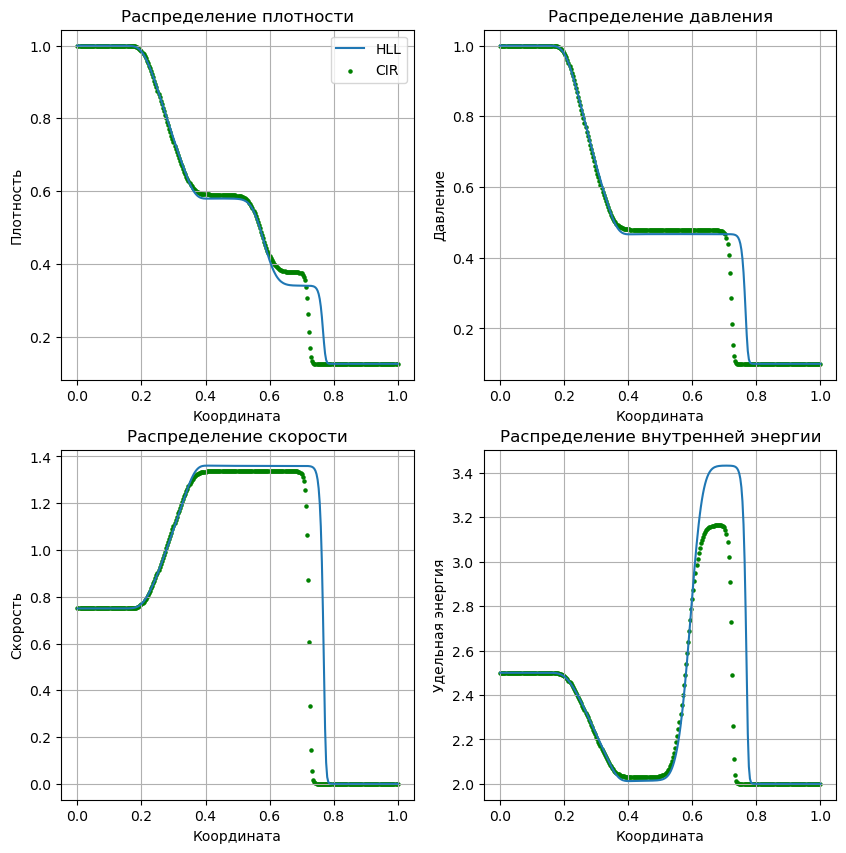

In [323]:
case1 = computation(1., 0.75, 1., 0.125, 0., 0.1, 1., 301, 0.2, 10e-5, 0.6, 0.3)
cir1 = CIR(1., 0.75, 1., 0.125, 0., 0.1, 1., 301, 0.2, 10e-5, 0.6, 0.3)
vec_coord = np.linspace(0.,1.,301)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].set_title('Распределение плотности')
_ = axs[0][0].set_xlabel('Координата')
_ = axs[0][0].set_ylabel('Плотность')
_ = axs[0][0].plot(vec_coord, case1[1], label = 'HLL')
_ = axs[0][0].scatter(vec_coord, cir1[1], color = 'green', s=5, label ='CIR')
_ = axs[0][0].grid()

axs[1][0].set_title('Распределение скорости')
_ = axs[1][0].set_xlabel('Координата')
_ = axs[1][0].set_ylabel('Скорость')
_ = axs[1][0].plot(vec_coord, case1[2])
_ = axs[1][0].scatter(vec_coord, cir1[2], color = 'green', s=5)
_ = axs[1][0].grid()

axs[0][1].set_title('Распределение давления')
_ = axs[0][1].set_xlabel('Координата')
_ = axs[0][1].set_ylabel('Давление')
_ = axs[0][1].plot(vec_coord, case1[0])
_ = axs[0][1].scatter(vec_coord, cir1[0], color = 'green', s=5)
_ = axs[0][1].grid()

axs[1][1].set_title('Распределение внутренней энергии')
_ = axs[1][1].set_xlabel('Координата')
_ = axs[1][1].set_ylabel('Удельная энергия')
_ = axs[1][1].plot(vec_coord, case1[3])
_ = axs[1][1].scatter(vec_coord, cir1[3], color = 'green', s=5)
_ = axs[1][1].grid()

axs[0][0].legend()


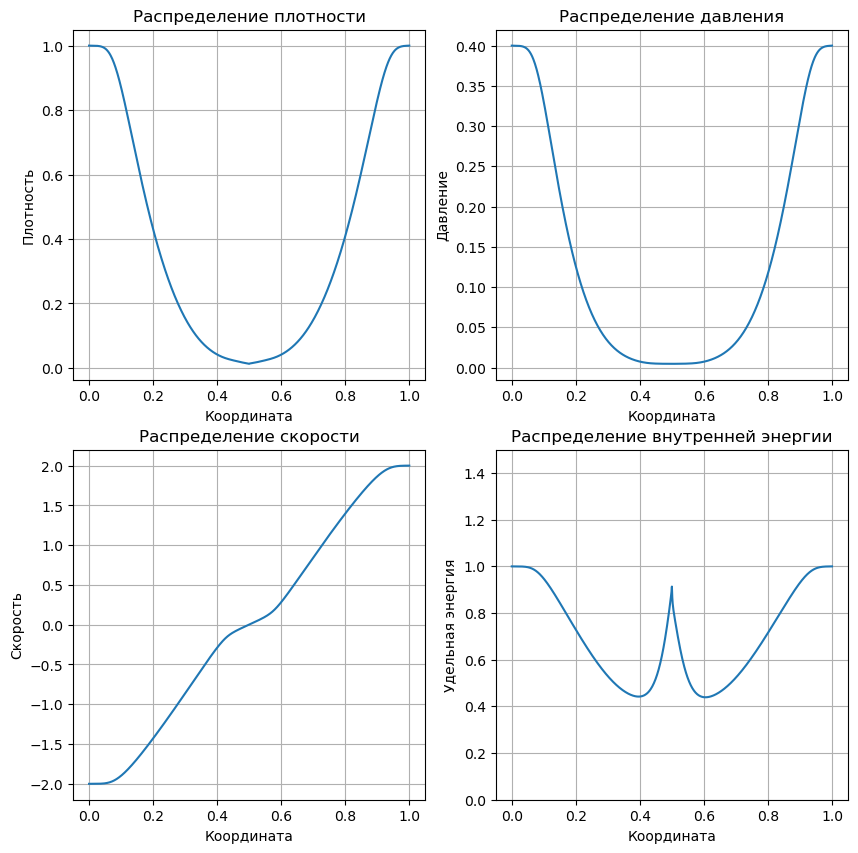

In [316]:
case2 = computation(1., -2., 0.4, 1., 2., 0.4, 1., 801, 0.15, 1.e-5, 0.2, 0.5)
vec_coord = np.linspace(0,1,801)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].set_title('Распределение плотности')
_ = axs[0][0].set_xlabel('Координата')
_ = axs[0][0].set_ylabel('Плотность')
_ = axs[0][0].plot(vec_coord, case2[1])
_ = axs[0][0].grid()

axs[1][0].set_title('Распределение скорости')
_ = axs[1][0].set_xlabel('Координата')
_ = axs[1][0].set_ylabel('Скорость')
_ = axs[1][0].plot(vec_coord, case2[2])
_ = axs[1][0].grid()

axs[0][1].set_title('Распределение давления')
_ = axs[0][1].set_xlabel('Координата')
_ = axs[0][1].set_ylabel('Давление')
_ = axs[0][1].plot(vec_coord, case2[0])
_ = axs[0][1].grid()

axs[1][1].set_title('Распределение внутренней энергии')
_ = axs[1][1].set_xlabel('Координата')
_ = axs[1][1].set_ylabel('Удельная энергия')
_ = axs[1][1].plot(vec_coord, case2[3])
_ = axs[1][1].set_ylim(0,1.5)
_ = axs[1][1].grid()

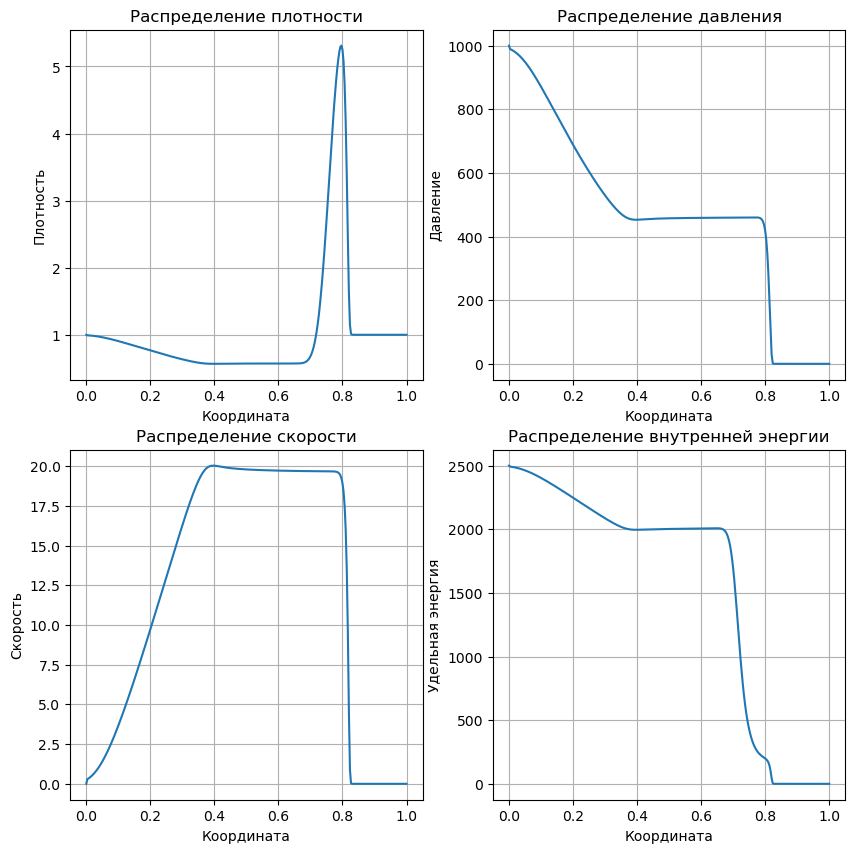

In [317]:
case3 = computation(1., 0., 1000., 1., 0., 0.01, 1., 301, 0.012, 10e-6, 0.2, 0.5)
vec_coord = np.linspace(0,1,301)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].set_title('Распределение плотности')
_ = axs[0][0].set_xlabel('Координата')
_ = axs[0][0].set_ylabel('Плотность')
_ = axs[0][0].plot(vec_coord, case3[1])
_ = axs[0][0].grid()

axs[1][0].set_title('Распределение скорости')
_ = axs[1][0].set_xlabel('Координата')
_ = axs[1][0].set_ylabel('Скорость')
_ = axs[1][0].plot(vec_coord, case3[2])
_ = axs[1][0].grid()

axs[0][1].set_title('Распределение давления')
_ = axs[0][1].set_xlabel('Координата')
_ = axs[0][1].set_ylabel('Давление')
_ = axs[0][1].plot(vec_coord, case3[0])
_ = axs[0][1].grid()

axs[1][1].set_title('Распределение внутренней энергии')
_ = axs[1][1].set_xlabel('Координата')
_ = axs[1][1].set_ylabel('Удельная энергия')
_ = axs[1][1].plot(vec_coord, case3[3])
_ = axs[1][1].grid()

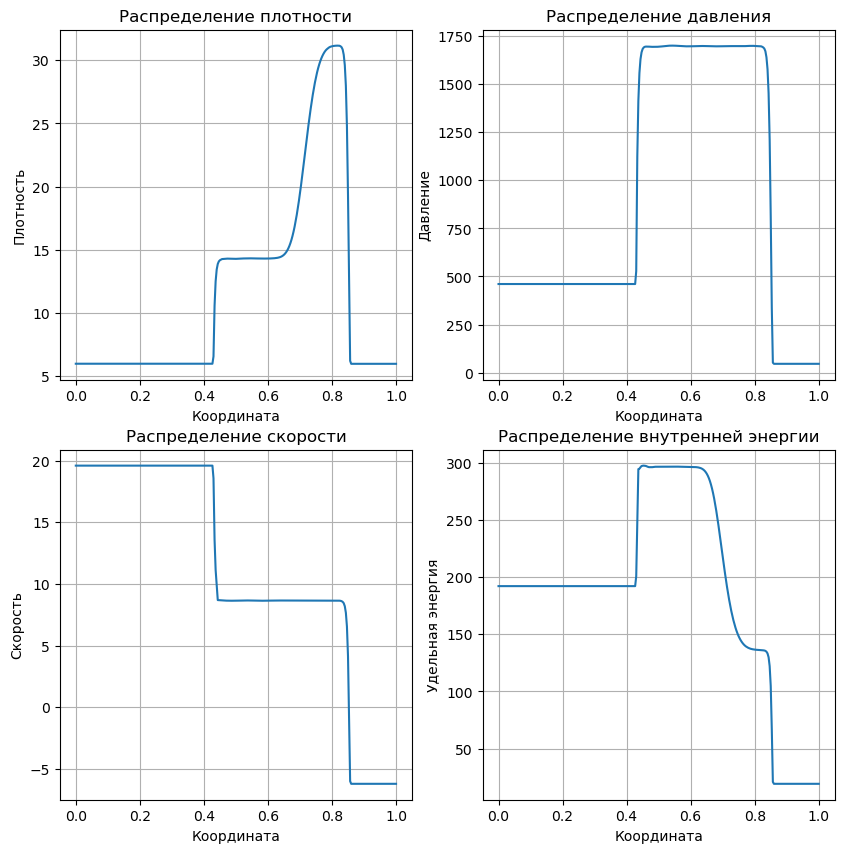

In [7]:
case4 = computation(5.99924, 19.5975, 460.894, 5.99242, -6.19633, 46.0950, 1, 301, 0.035, 10e-6, 0.2, 0.4)
vec_coord = np.linspace(0.,1.,301)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

rho = monoton(case4[1])
u = monoton(case4[2])
p = monoton(case4[0])
E = monoton(case4[3])

axs[0][0].set_title('Распределение плотности')
_ = axs[0][0].set_xlabel('Координата')
_ = axs[0][0].set_ylabel('Плотность')
_ = axs[0][0].plot(vec_coord, rho)
_ = axs[0][0].grid()

axs[1][0].set_title('Распределение скорости')
_ = axs[1][0].set_xlabel('Координата')
_ = axs[1][0].set_ylabel('Скорость')
_ = axs[1][0].plot(vec_coord, u)
_ = axs[1][0].grid()

axs[0][1].set_title('Распределение давления')
_ = axs[0][1].set_xlabel('Координата')
_ = axs[0][1].set_ylabel('Давление')
_ = axs[0][1].plot(vec_coord, p)
_ = axs[0][1].grid()

axs[1][1].set_title('Распределение внутренней энергии')
_ = axs[1][1].set_xlabel('Координата')
_ = axs[1][1].set_ylabel('Удельная энергия')
_ = axs[1][1].plot(vec_coord, case4[3])
_ = axs[1][1].grid()

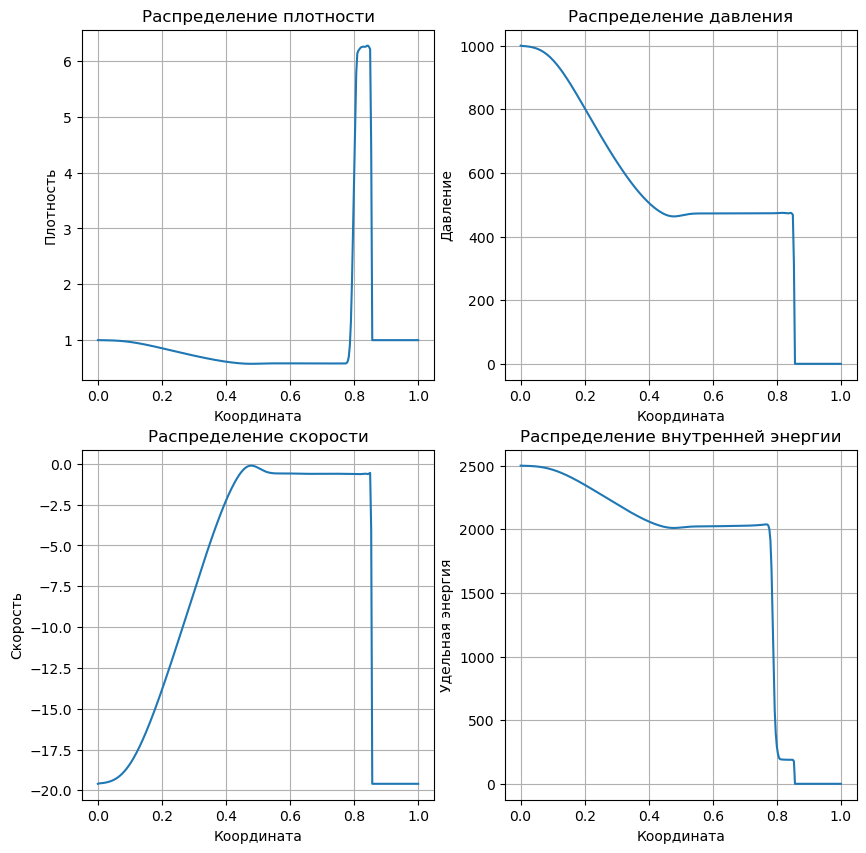

In [319]:
case5 = computation(1., -19.59745, 1000., 1., -19.59745, 0.01, 1, 301, 0.012, 10e-6, 0.2, 0.8)
vec_coord = np.linspace(0.,1.,301)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].set_title('Распределение плотности')
_ = axs[0][0].set_xlabel('Координата')
_ = axs[0][0].set_ylabel('Плотность')
_ = axs[0][0].plot(vec_coord, case5[1])
_ = axs[0][0].grid()

axs[1][0].set_title('Распределение скорости')
_ = axs[1][0].set_xlabel('Координата')
_ = axs[1][0].set_ylabel('Скорость')
_ = axs[1][0].plot(vec_coord, case5[2])
_ = axs[1][0].grid()

axs[0][1].set_title('Распределение давления')
_ = axs[0][1].set_xlabel('Координата')
_ = axs[0][1].set_ylabel('Давление')
_ = axs[0][1].plot(vec_coord, case5[0])
_ = axs[0][1].grid()

axs[1][1].set_title('Распределение внутренней энергии')
_ = axs[1][1].set_xlabel('Координата')
_ = axs[1][1].set_ylabel('Удельная энергия')
_ = axs[1][1].plot(vec_coord, case5[3])
_ = axs[1][1].grid()

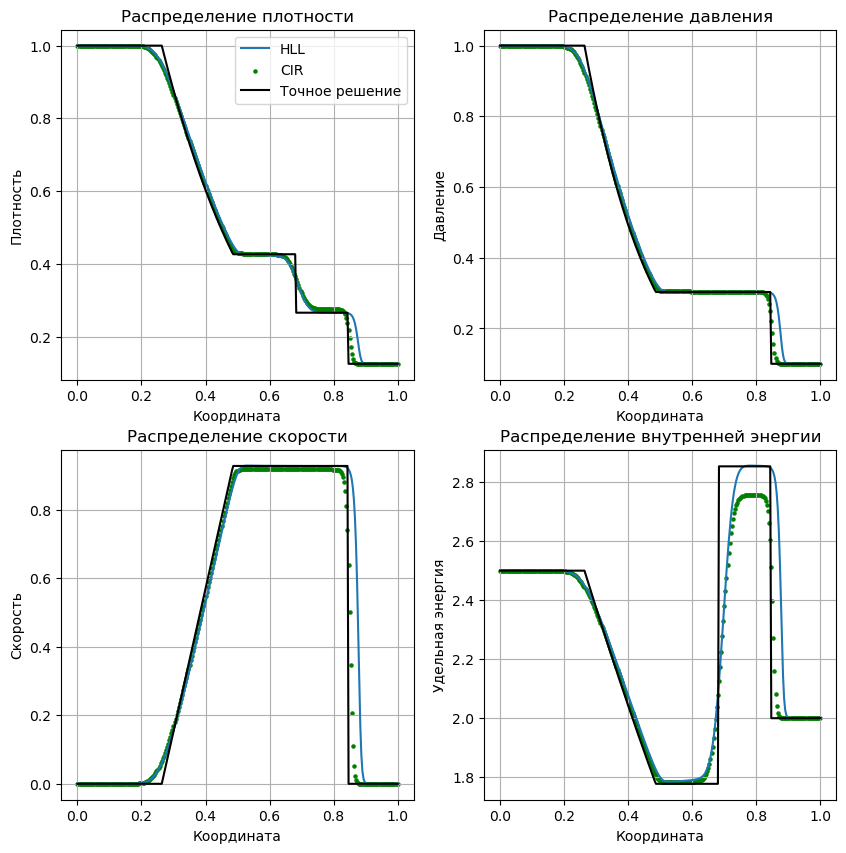

In [320]:
def f(P, pL, pR, cL, cR, gg):
    a = (gg-1)*(cR/cL)*(P-1) 
    b = np.sqrt( 2*gg*(2*gg + (gg+1)*(P-1) ) )
    return P - pL/pR*( 1 - a/b )**(2.*gg/(gg-1.))

# Аналитическое решение для ударной волны
def SodShockAnalytic(rL, uL, pL, rR, uR, pR, xs, x0, T, gg):
    dx = xs[1]
    Nx = len(xs)
    v_analytic = np.zeros((3,Nx),dtype='float64')

    # Скорость звука
    cL = np.sqrt(gg*pL/rL); 
    cR = np.sqrt(gg*pR/rR);
    P = newton(f, 0.5, args=(pL, pR, cL, cR, gg), tol=1e-12)

    # Справа
    c_shock = uR + cR*np.sqrt( (gg-1+P*(gg+1)) / (2*gg) )
    x_shock = x0 + int(np.floor(c_shock*T/dx))
    v_analytic[0,x_shock-1:] = rR
    v_analytic[1,x_shock-1:] = uR
    v_analytic[2,x_shock-1:] = pR
    
    # Область 2
    alpha = (gg+1)/(gg-1)
    c_contact = uL + 2*cL/(gg-1)*( 1-(P*pR/pL)**((gg-1.)/2/gg) )
    x_contact = x0 + int(np.floor(c_contact*T/dx))
    v_analytic[0,x_contact:x_shock-1] = (1 + alpha*P)/(alpha+P)*rR
    v_analytic[1,x_contact:x_shock-1] = c_contact
    v_analytic[2,x_contact:x_shock-1] = P*pR
    
    # Область 3
    r3 = rL*(P*pR/pL)**(1/gg);
    p3 = P*pR
    c_fanright = c_contact - np.sqrt(gg*p3/r3)
    x_fanright = x0 + int(np.ceil(c_fanright*T/dx))
    v_analytic[0,x_fanright:x_contact] = r3
    v_analytic[1,x_fanright:x_contact] = c_contact
    v_analytic[2,x_fanright:x_contact] = P*pR
    
    # Область 4
    c_fanleft = -cL
    x_fanleft = x0 + int(np.ceil(c_fanleft*T/dx))
    u4 = 2 / (gg+1) * (cL + (xs[x_fanleft:x_fanright]-xs[x0])/T )
    v_analytic[0,x_fanleft:x_fanright] = rL*(1 - (gg-1)/2.*u4/cL)**(2/(gg-1))
    v_analytic[1,x_fanleft:x_fanright] = u4;
    v_analytic[2,x_fanleft:x_fanright] = pL*(1 - (gg-1)/2.*u4/cL)**(2*gg/(gg-1))

    # Слева
    v_analytic[0,:x_fanleft] = rL
    v_analytic[1,:x_fanleft] = uL
    v_analytic[2,:x_fanleft] = pL

    return v_analytic

rL, uL, pL =  1.0,  0., 1.
rR, uR, pR = 0.125, 0., 0.1

# Set Disretization
Nx = 301
X = 1.
dx = X/(Nx-1)
xs = np.linspace(0,X,Nx)
x0 = Nx//2
T = 0.2

analytic = SodShockAnalytic(rL, uL, pL, rR, uR, pR, xs, x0, T, gamma)

case_test = computation(1., 0., 1., 0.125, 0., 0.1, 1, 301, 0.2, 10e-5, 0.6, 0.5)

case_cir = CIR(1., 0., 1., 0.125, 0., 0.1, 1, 301, 0.2, 10e-5, 0.6, 0.5)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0][0].set_title('Распределение плотности')
_ = axs[0][0].set_xlabel('Координата')
_ = axs[0][0].set_ylabel('Плотность')
_ = axs[0][0].plot(vec_coord, case_test[1], label = 'HLL')
_ = axs[0][0].scatter(vec_coord, case_cir[1], color = 'green', s=5, label = 'CIR')
_ = axs[0][0].plot(xs, analytic[0].T, color = 'black', label = 'Точное решение')
_ = axs[0][0].grid()

axs[1][0].set_title('Распределение скорости')
_ = axs[1][0].set_xlabel('Координата')
_ = axs[1][0].set_ylabel('Скорость')
_ = axs[1][0].plot(vec_coord, case_test[2])
_ = axs[1][0].scatter(vec_coord, case_cir[2], color = 'green', s=5)
_ = axs[1][0].plot(xs, analytic[1].T, color = 'black')
_ = axs[1][0].grid()

axs[0][1].set_title('Распределение давления')
_ = axs[0][1].set_xlabel('Координата')
_ = axs[0][1].set_ylabel('Давление')
_ = axs[0][1].plot(vec_coord, case_test[0])
_ = axs[0][1].scatter(vec_coord, case_cir[0], color = 'green', s=5)
_ = axs[0][1].plot(xs, analytic[2].T, color = 'black')
_ = axs[0][1].grid()

axs[1][1].set_title('Распределение внутренней энергии')
_ = axs[1][1].set_xlabel('Координата')
_ = axs[1][1].set_ylabel('Удельная энергия')
_ = axs[1][1].plot(vec_coord, case_test[3])
_ = axs[1][1].scatter(vec_coord, case_cir[3], color = 'green', s=5)
_ = axs[1][1].plot(xs, analytic[2].T/analytic[0].T/(gamma-1), color = 'black')
_ = axs[1][1].grid()

axs[0][0].legend()
